In [ ]:
from pathlib import Path
from drone_detector.tiling import *
from drone_detector.utils import *
import os, sys
import geopandas as gpd
import pandas as pd
import rasterio as rio
import math
from shapely.geometry import box
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
from shapely.geometry import Point 

def get_len(geom):
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

# All data distributions

In [ ]:
full_data = gpd.read_file('../data/hiidenportti/raw/merged_anns_buffered_envelope_filtered.geojson')

Remove empty geometries that for some reason exist.

In [ ]:
full_data.dropna(subset=['geometry'], inplace=True)

Fix polygons so that they are not MultiPolygons and do not contain any holes.

In [ ]:
full_data['geometry'] = full_data.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                        else Polygon(row.geometry.exterior), axis=1)

Get some information, assume that GSD is 0.04m. Depending on the mosaic it's really between 0.039m and 0.044m.

In [ ]:
full_data['area'] = full_data.geometry.area

In [ ]:
full_data['pixel_area'] = full_data.area / 0.04**2

In [ ]:
full_data['bbox_area'] = full_data.apply(lambda row: box(*row.geometry.bounds).area, axis=1)

In [ ]:
full_data['bbox_x_px'] = full_data.apply(lambda row: (row.geometry.bounds[2] - row.geometry.bounds[0]) / 0.04, axis=1)
full_data['bbox_y_px'] = full_data.apply(lambda row: (row.geometry.bounds[3] - row.geometry.bounds[1]) / 0.04, axis=1)

In [ ]:
full_data['bbox_pixel_area'] = full_data.bbox_area / 0.04**2

In [ ]:
def aspect_ratio(row):
    if row.bbox_x_px > row.bbox_y_px:
        return row.bbox_x_px / row.bbox_y_px
    else:
        return - (row.bbox_y_px) / (row.bbox_x_px)

In [ ]:
#full_data['bbox_aspect_ratio'] = full_data.apply(lambda row: aspect_ratio(row), axis=1)#
full_data['bbox_aspect_ratio'] = full_data.bbox_x_px / full_data.bbox_y_px

In [ ]:
full_data['coco_scale'] = full_data.apply(lambda row: 'small' if row.pixel_area < 32**2 
                                          else ('large' if row.pixel_area > 96**2 else 'medium'), axis=1)

COCO scales are divided by pixel area. `small` is less than $32^2$ pixels, `large` is more than $96^2$ pixels and `medium` is between them.

In [ ]:
pd.crosstab(full_data.layer, full_data.coco_scale, margins=True)

coco_scale,large,medium,small,All
layer,,,,
groundwood,0,165,6879,7044
uprightwood,7,709,298,1014
All,7,874,7177,8058


As seen here, almost all of the annotated groundwood are considered `small`, while annotated uprightwood are mostly `medium`.

Area of different deadwood types, in m²

In [ ]:
pd.pivot_table(full_data, index='layer', values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
layer,,,,
groundwood,0.047540,5.789380,0.485191,0.363754
uprightwood,0.192411,24.334151,3.462446,2.645389
All,0.047540,24.334151,0.859842,0.409054


In [ ]:
full_data[full_data.layer == 'uprightwood'].area.sum()

3510.9206202328805

In [ ]:
full_data[full_data.layer == 'groundwood'].area.sum()

3417.685918208299

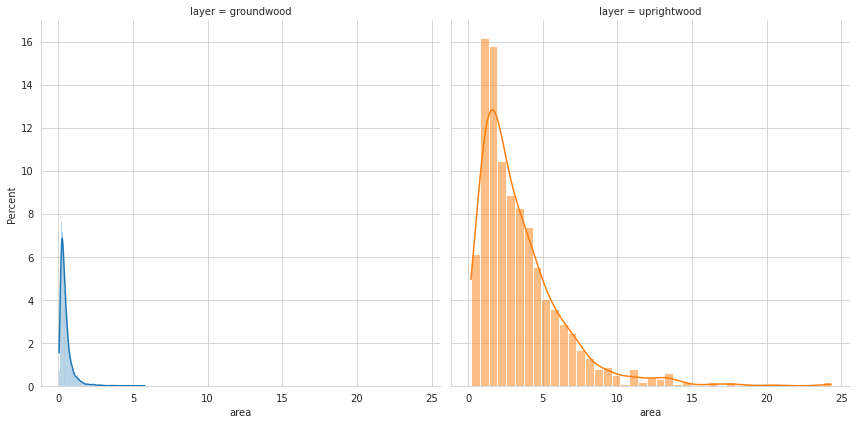

In [ ]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'area', kde=True, stat='percent')

Approximate area in pixels, average resolution around 0.04m so each pixel is 0.0016m²

In [ ]:
pd.pivot_table(full_data, index='layer', values='pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,pixel_area,pixel_area,pixel_area,pixel_area
layer,,,,
groundwood,29.712529,3618.362518,303.244421,227.345998
uprightwood,120.256655,15208.844475,2164.028982,1653.368160
All,29.712529,15208.844475,537.401227,255.658468


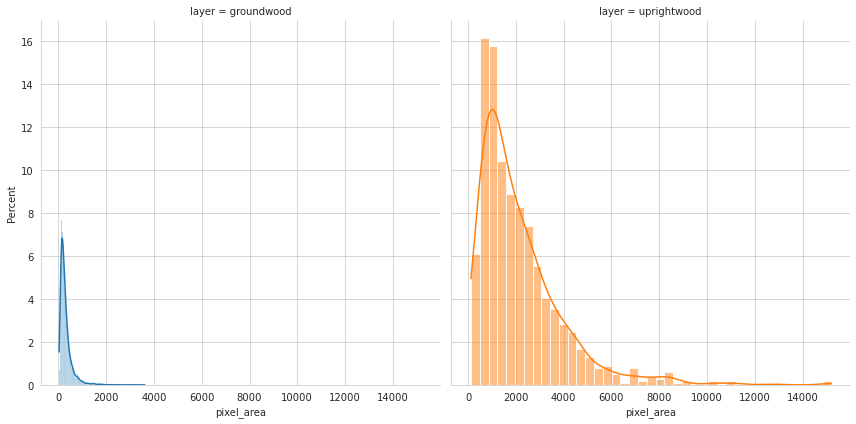

In [ ]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'pixel_area', kde=True, stat='percent')

Area of bounding boxes, in pixels.

In [ ]:
pd.pivot_table(full_data, index='layer', values='bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area
layer,,,,
groundwood,48.167026,61448.771422,1923.289864,915.602335
uprightwood,163.695888,36788.901590,3620.390876,2662.253413
All,48.167026,61448.771422,2136.849113,1046.128835


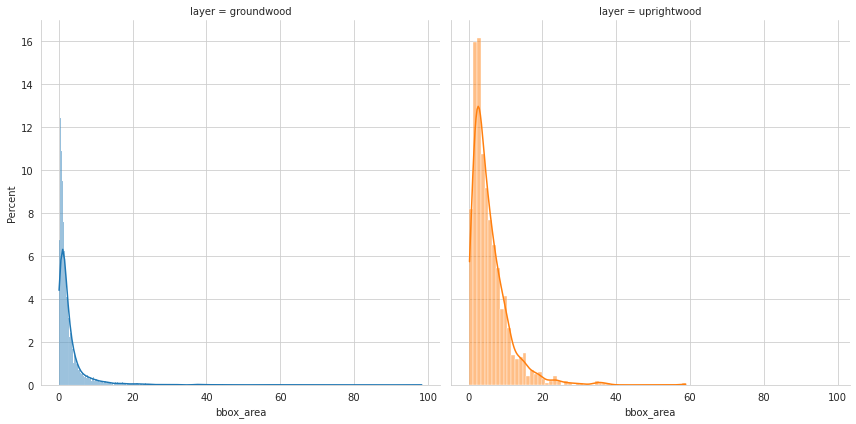

In [ ]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'bbox_area', kde=True, stat='percent')

Aspect (width / height) ratios of bounding boxes. For reference, default ratios for Mask R-CNN are 0.5, 1, 2 so region proporsals are in 1:2, 1:1 or 2:1 ratio. Here aspect ratios for boxes with height > width are presented as negative.

In [ ]:
pd.pivot_table(full_data, index='layer', values='bbox_aspect_ratio', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio
layer,,,,
groundwood,0.025544,27.285714,1.697633,0.953488
uprightwood,0.389831,2.412371,1.034837,1.007602
All,0.025544,27.285714,1.614228,0.969250


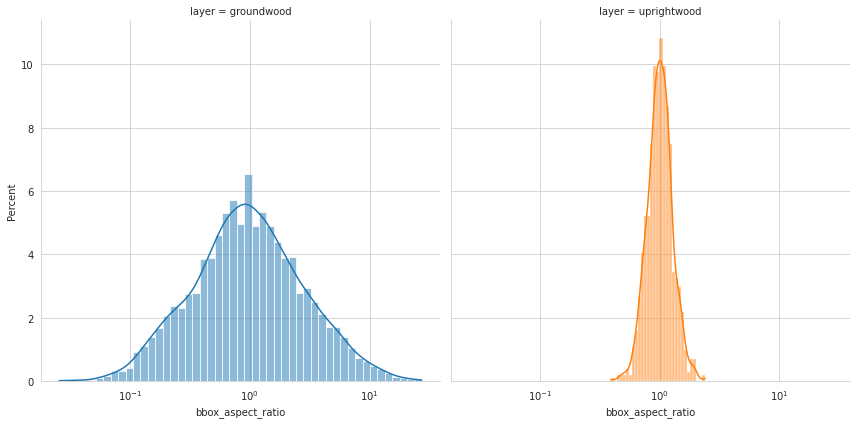

In [ ]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'bbox_aspect_ratio', kde=True, stat='percent',log_scale=True)

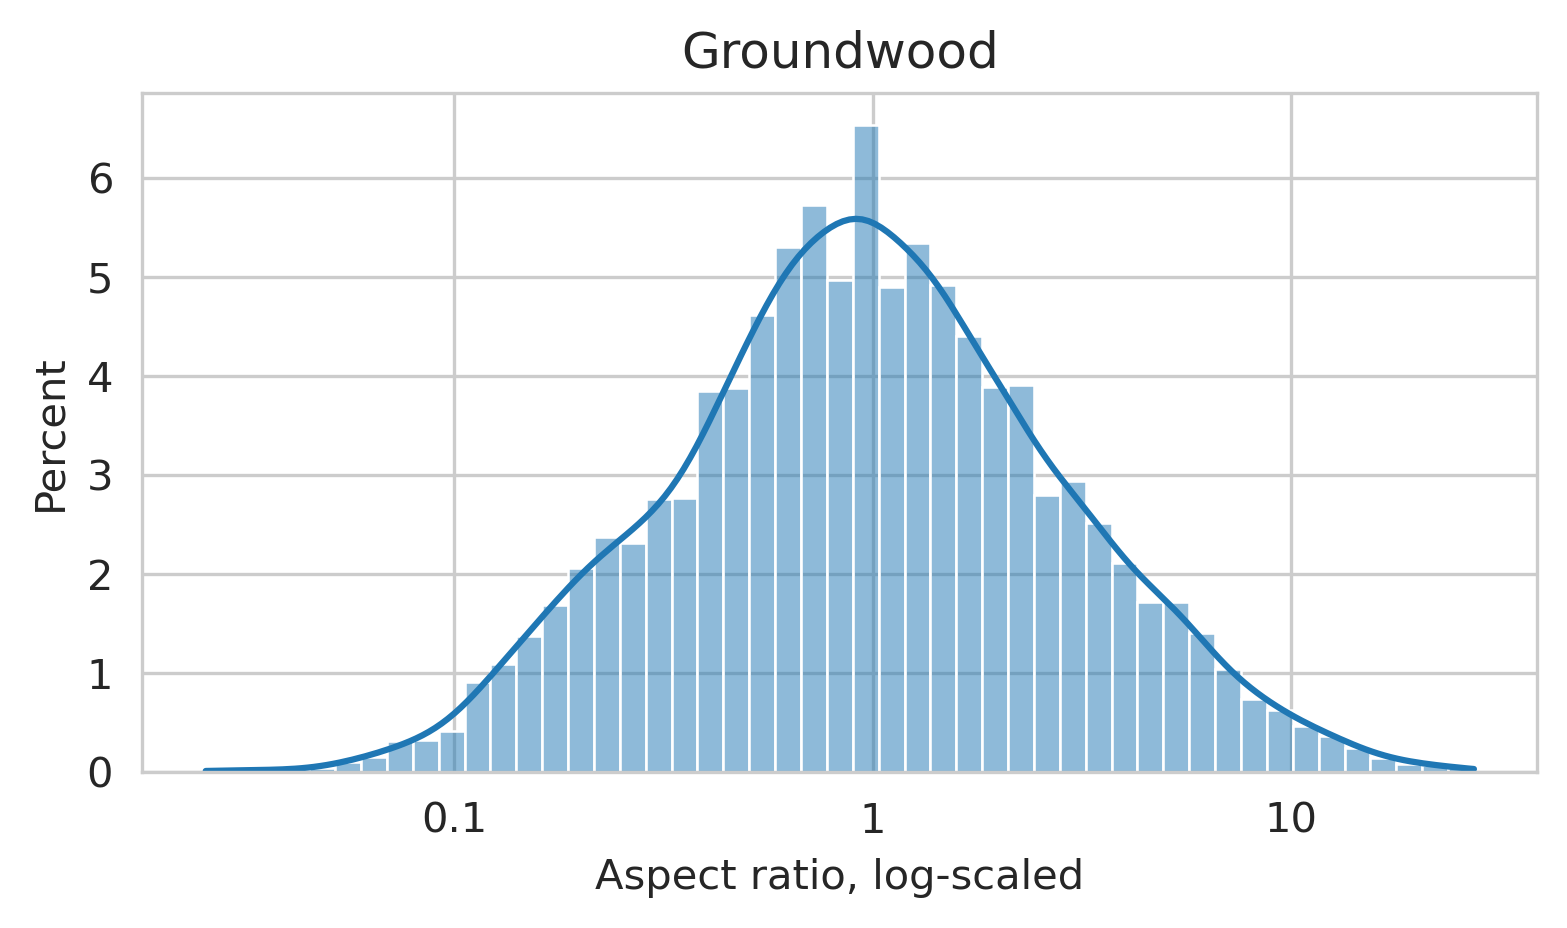

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=300)
sns.histplot(full_data[full_data.layer=='groundwood'], x='bbox_aspect_ratio', kde=True, stat='percent', ax=ax, log_scale=True)
ax.set_title('Groundwood')
ax.set_xlabel('Aspect ratio, log-scaled')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
plt.savefig('../data/figures/bbox_groundwood.jpeg', bbox_inches='tight', dpi=300)

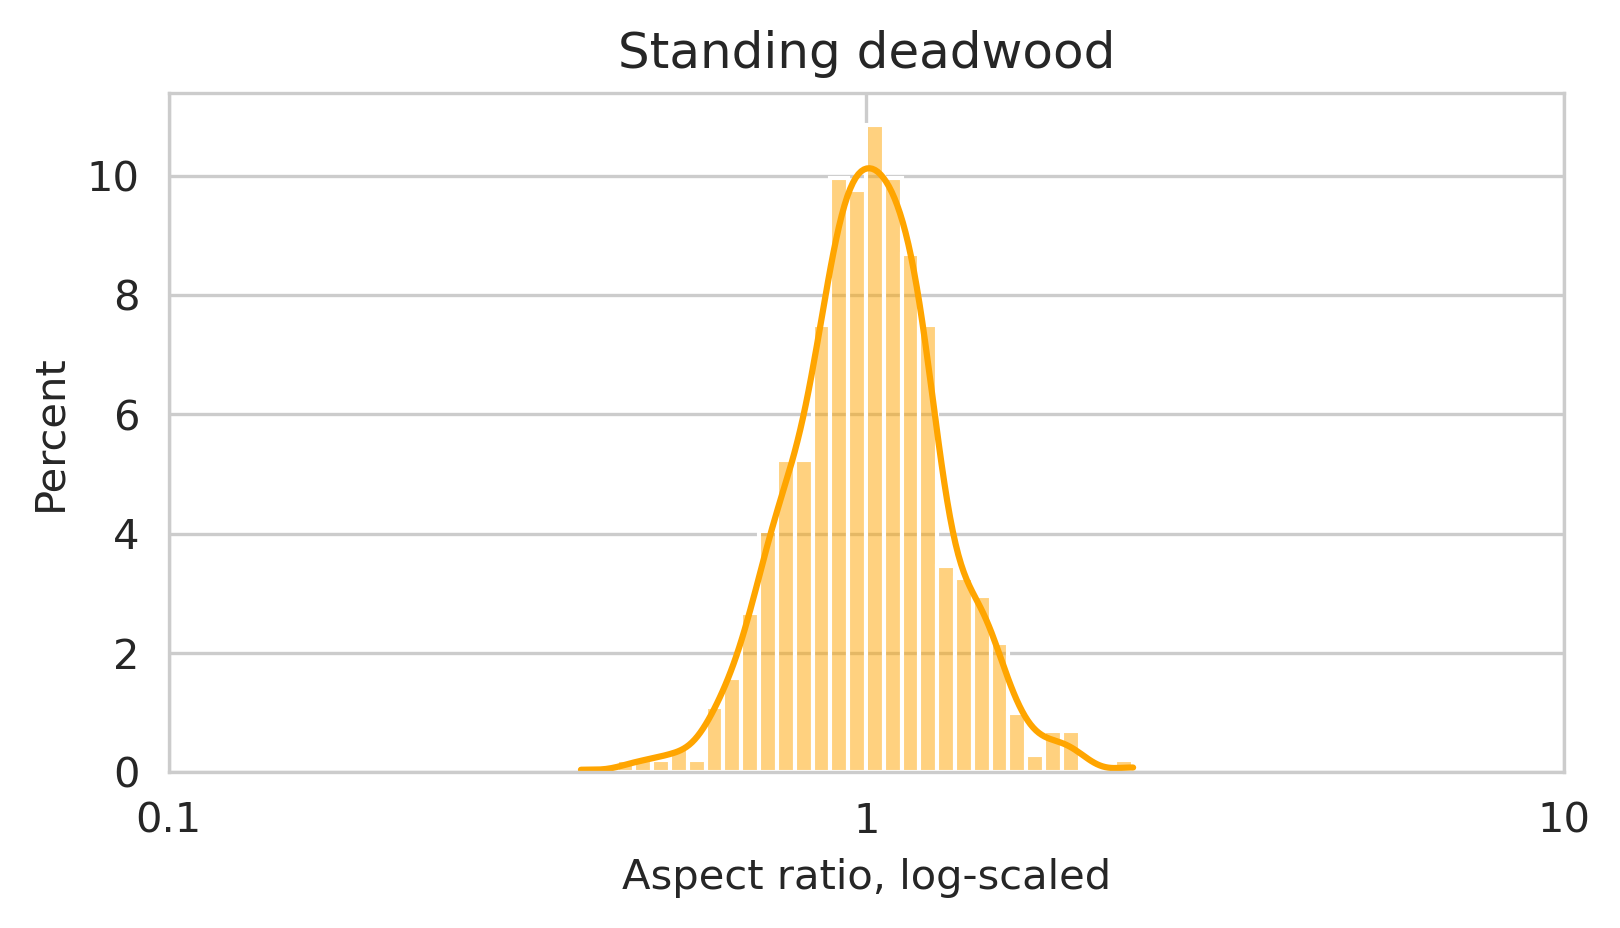

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=300)
sns.histplot(full_data[full_data.layer=='uprightwood'], x='bbox_aspect_ratio', 
             kde=True, stat='percent', ax=ax, log_scale=True, color='orange')
ax.set_title('Standing deadwood')
ax.set_xlabel('Aspect ratio, log-scaled')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
plt.savefig('../data/figures/bbox_upright.jpeg', bbox_inches='tight', dpi=300)

As expected, groundwood has weird aspect ratios.

<AxesSubplot:xlabel='bbox_pixel_area', ylabel='bbox_aspect_ratio'>

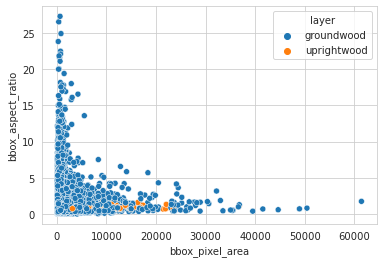

In [ ]:
sns.scatterplot(data=full_data, x='bbox_pixel_area', y='bbox_aspect_ratio', hue='layer')

Widths of bounding boxes, in pixels. Default anchor sizes for Mask R-CNN are 32, 64, 128, 256 and 512 pixels, but for images with minimum width of 800px and maximum width of 1333px. Our images are tiled into 512 pixels and upsampled to 800x800 pixels before feeding to the model so these bounding boxes are a bit larger.

In [ ]:
pd.pivot_table(full_data, index='layer', values='bbox_x_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_x_px,bbox_x_px,bbox_x_px,bbox_x_px
layer,,,,
groundwood,2.652846,330.083905,41.167346,31.982167
uprightwood,11.211381,205.823571,55.908559,52.513028
All,2.652846,330.083905,43.022346,34.770950


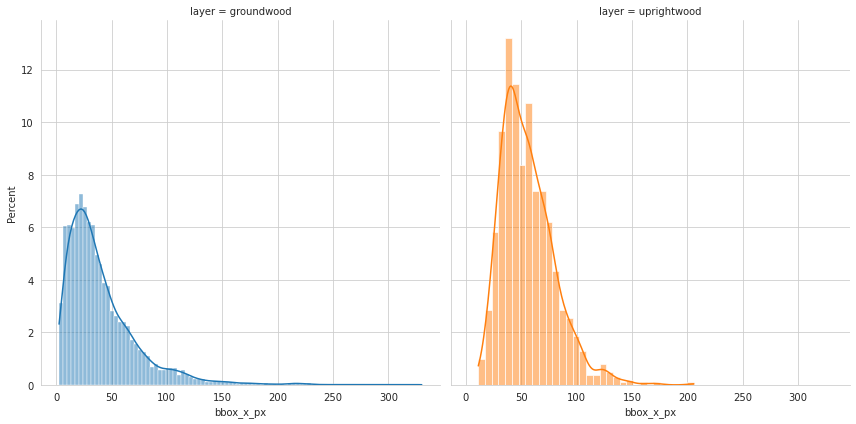

In [ ]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'bbox_x_px', kde=True, stat='percent')

In [ ]:
full_data['bbox_x_scaled'] = full_data.bbox_x_px * 800/512
pd.pivot_table(full_data, index='layer', values='bbox_x_scaled', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_x_scaled,bbox_x_scaled,bbox_x_scaled,bbox_x_scaled
layer,,,,
groundwood,4.145071,515.756102,64.323977,49.972136
uprightwood,17.517782,321.599330,87.357123,82.051606
All,4.145071,515.756102,67.222415,54.329610


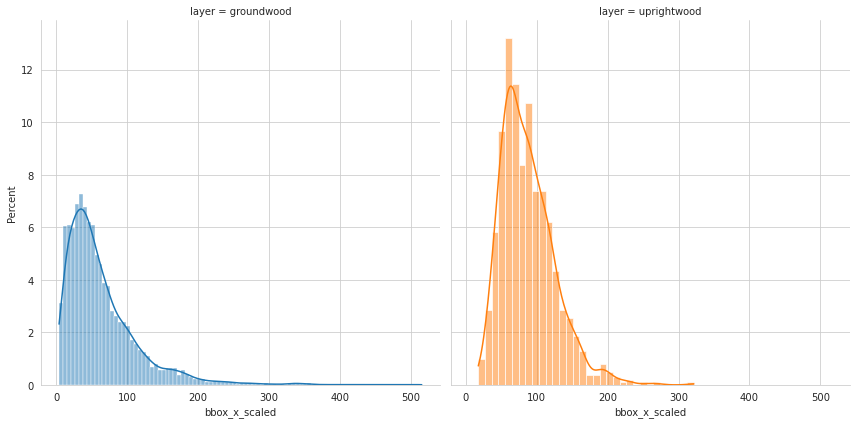

In [ ]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'bbox_x_scaled', kde=True, stat='percent')

Heights of bounding boxes, in pixels.

In [ ]:
pd.pivot_table(full_data, index='layer', values='bbox_y_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_y_px,bbox_y_px,bbox_y_px,bbox_y_px
layer,,,,
groundwood,2.828403,384.561058,41.339821,32.836223
uprightwood,14.600868,178.739983,55.790557,51.395807
All,2.828403,384.561058,43.158268,35.806890


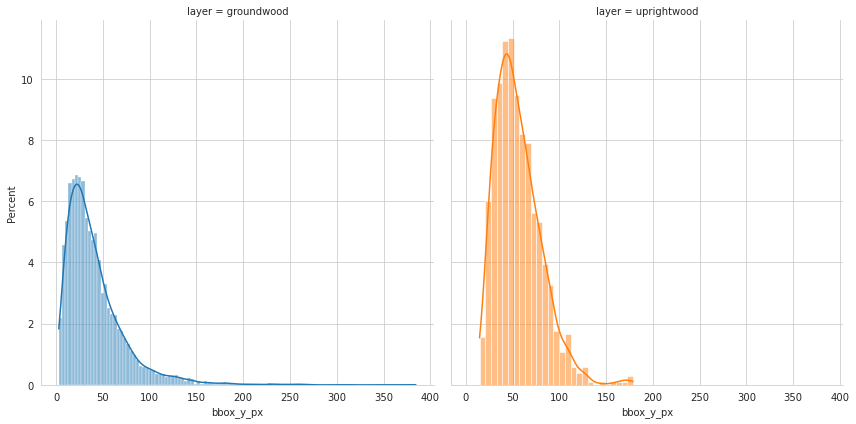

In [ ]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'bbox_y_px', kde=True, stat='percent')

In [ ]:
full_data['bbox_y_scaled'] = full_data.bbox_y_px * 800/512
pd.pivot_table(full_data, index='layer', values='bbox_y_scaled', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_y_scaled,bbox_y_scaled,bbox_y_scaled,bbox_y_scaled
layer,,,,
groundwood,4.419379,600.876652,64.593470,51.306599
uprightwood,22.813856,279.281223,87.172745,80.305948
All,4.419379,600.876652,67.434793,55.948266


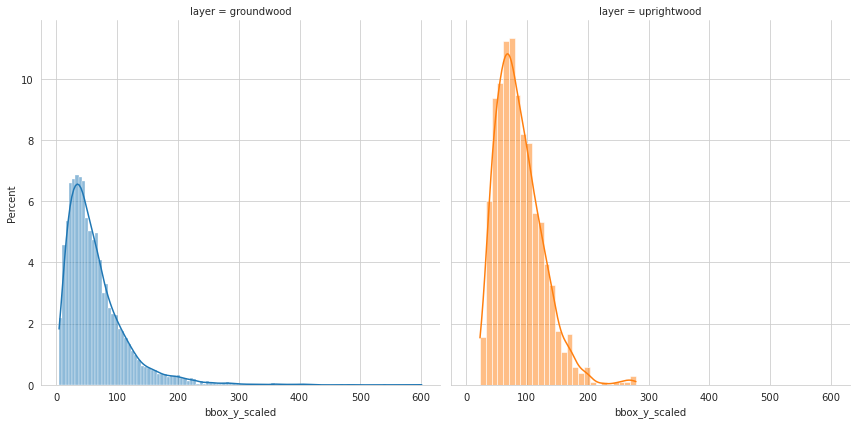

In [ ]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'bbox_y_scaled', kde=True, stat='percent')

<AxesSubplot:xlabel='bbox_x_scaled', ylabel='bbox_y_scaled'>

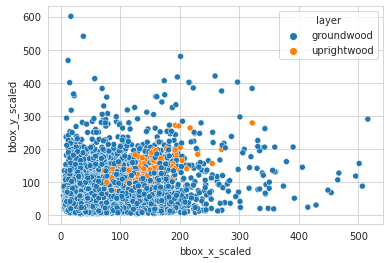

In [ ]:
sns.scatterplot(data=full_data, x='bbox_x_scaled', y='bbox_y_scaled', hue='layer')

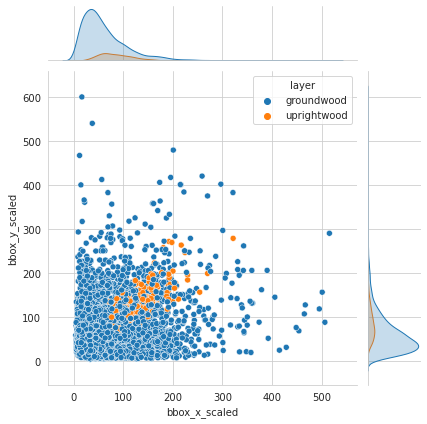

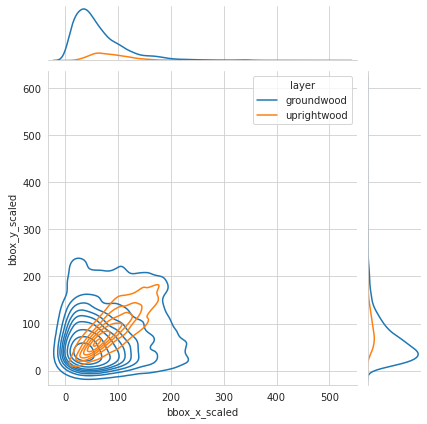

In [ ]:
sns.jointplot(x="bbox_x_scaled", y="bbox_y_scaled", data=full_data, hue='layer')
sns.jointplot(x="bbox_x_scaled", y="bbox_y_scaled", data=full_data, kind='kde', hue='layer')

Length (groundwood) and maximum canopy radius (uprightwood) of the annotated polygons

In [ ]:
full_data['tree_length'] = full_data.apply(lambda row: get_len(row.geometry), axis=1)

In [ ]:
pd.pivot_table(full_data, index=['conservation', 'layer'], 
               values=['tree_length'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

min         max        mean      median  \
                         tree_length tree_length tree_length tree_length   
conservation layer                                                         
0            groundwood     0.357993   15.383351    2.310062    1.957062   
             uprightwood    0.575769    6.977358    2.406676    2.248127   
1            groundwood     0.346741   15.087245    2.891665    2.394812   
             uprightwood    0.633733    8.313442    2.389709    2.218285   
All                         0.346741   15.383351    2.472940    2.100698   

                               count  
                         tree_length  
conservation layer                    
0            groundwood         4938  
             uprightwood         404  
1            groundwood         2106  
             uprightwood         610  
All                             8058

Text(0.5, 0, 'Length of the trunk in meters')

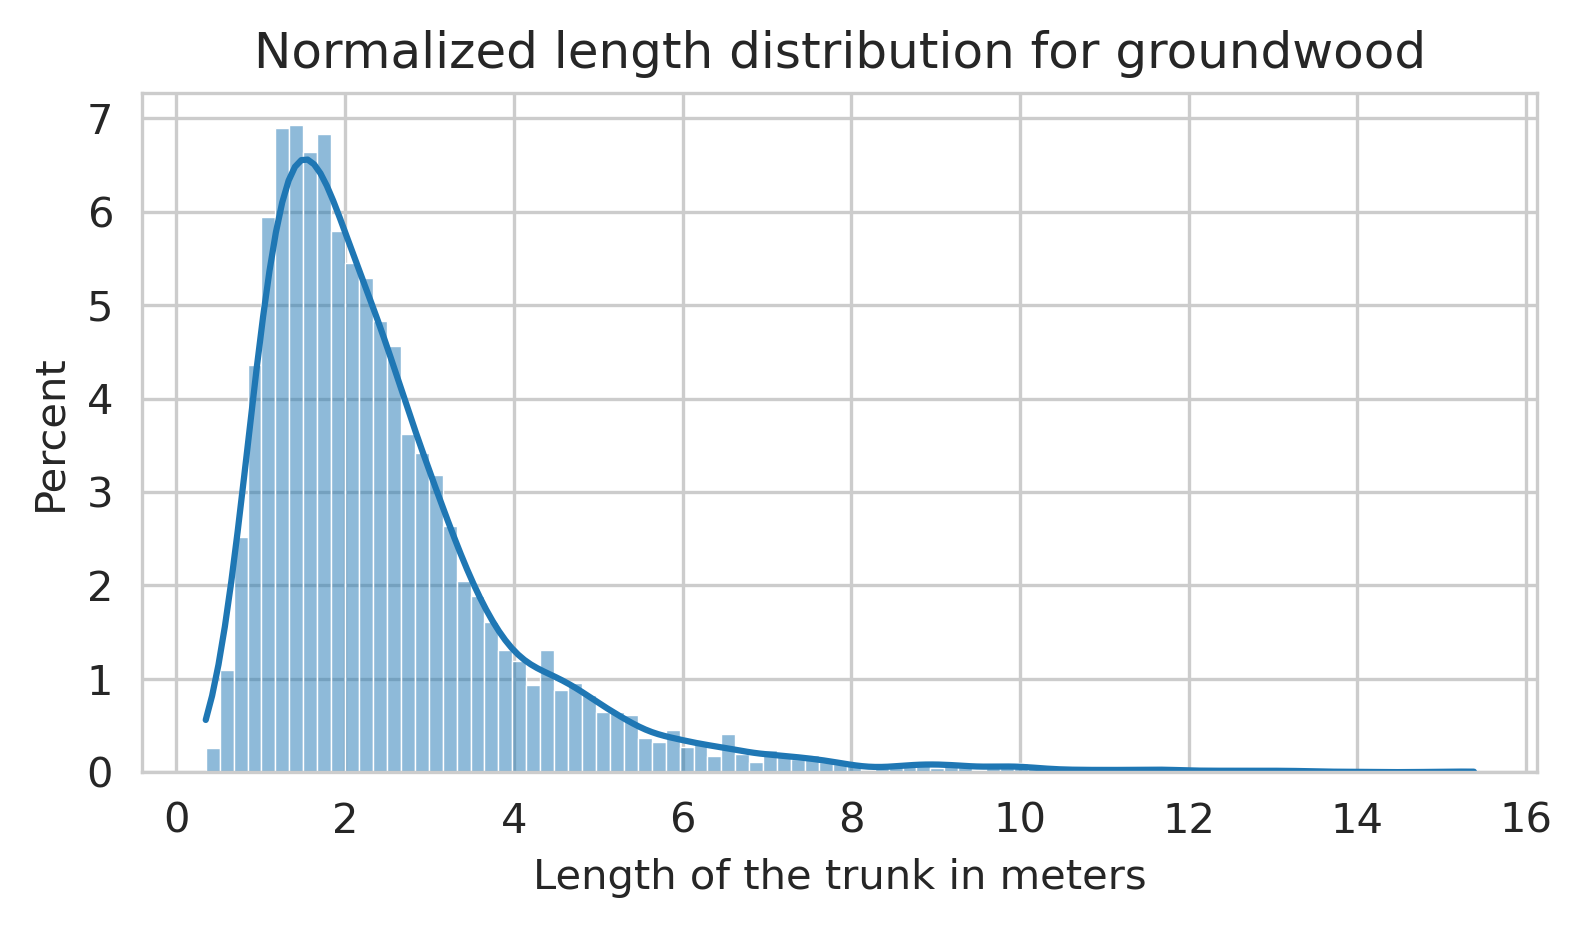

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=300)
sns.histplot(full_data[(full_data.layer=='groundwood')], x='tree_length', kde=True, stat='percent', ax=ax)
ax.set_title('Normalized length distribution for groundwood')
ax.set_xlabel('Length of the trunk in meters')
plt.savefig('../data/figures/len_dist.jpeg', bbox_inches='tight', dpi=300)

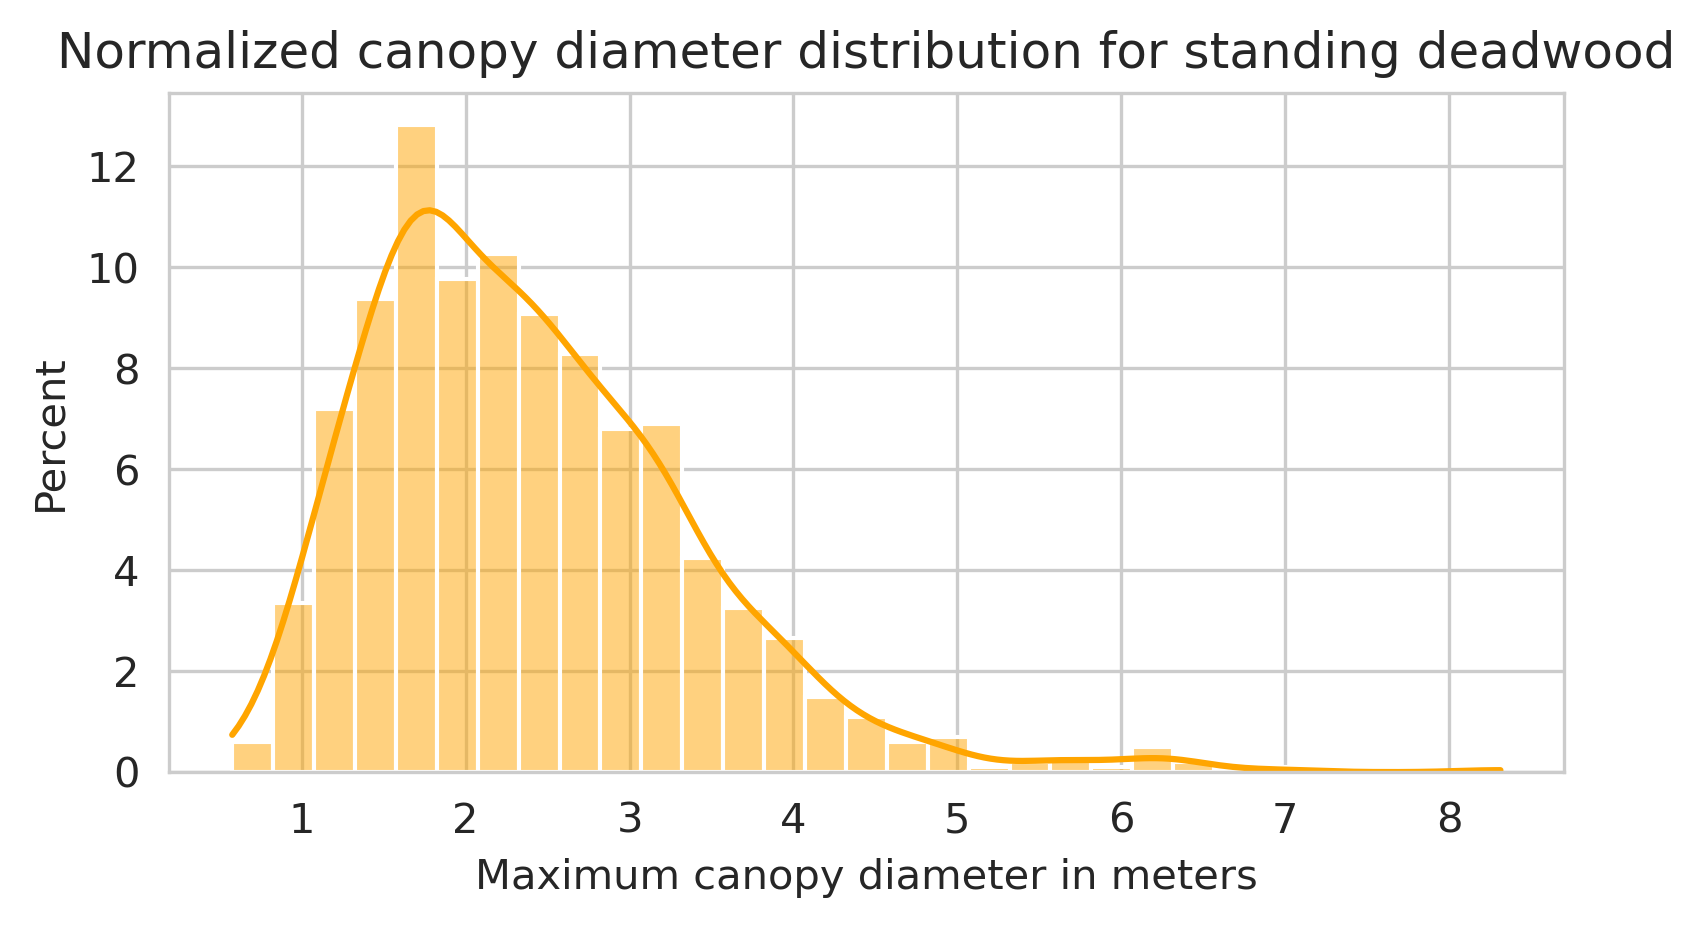

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=300)
sns.histplot(full_data[full_data.layer=='uprightwood'], x='tree_length', kde=True, stat='percent', ax=ax, color='orange')
ax.set_title('Normalized canopy diameter distribution for standing deadwood')
ax.set_xlabel('Maximum canopy diameter in meters')
plt.savefig('../data/figures/diam_dist.jpeg', bbox_inches='tight', dpi=300)

# Patch-level distributions for training data

In [ ]:
data_path = Path('../data/hiidenportti/processed_test/')
folders = [f for f in os.listdir(data_path) if os.path.isdir(data_path/f)]

In [ ]:
collated_patch_gdf = None

for im in folders:
    vectors = [f for f in os.listdir(data_path/im/'vector_tiles')]
    
    for v in vectors:
        tempgdf = gpd.read_file(data_path/im/f'vector_tiles/{v}')
        tempgdf['patch_id'] = f'{v}_{im}'
        tempgdf['im_id'] = im
        if collated_patch_gdf is None:
            collated_patch_gdf = tempgdf
        else:
            collated_patch_gdf = collated_patch_gdf.append(tempgdf)

In [ ]:
collated_patch_gdf.shape

(1547, 6)

In [ ]:
pd.crosstab(collated_patch_gdf.patch_id, collated_patch_gdf.layer)

layer,groundwood,uprightwood
patch_id,,
R0C0.geojson_104_32_Hiidenportti_Chunk5_orto,5,1
R0C0.geojson_104_41_Hiidenportti_Chunk8_orto,20,1
R0C0.geojson_104_42_Hiidenportti_Chunk5_orto,0,1
R0C0.geojson_104_49_Hiidenportti_Chunk5_orto,3,1
R0C0.geojson_104_73_Hiidenportti_Chunk9_orto,2,0
...,...,...
R7C0.geojson_104_42_Hiidenportti_Chunk5_orto,15,1
R7C1.geojson_104_42_Hiidenportti_Chunk5_orto,9,3
R7C2.geojson_104_42_Hiidenportti_Chunk5_orto,22,2


In [ ]:
collated_patch_gdf.layer.value_counts(normalize=True)

groundwood     0.806076
uprightwood    0.193924
Name: layer, dtype: float64

<AxesSubplot:>

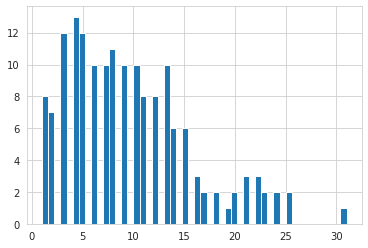

In [ ]:
collated_patch_gdf.patch_id.value_counts().hist(bins=50)

<AxesSubplot:>

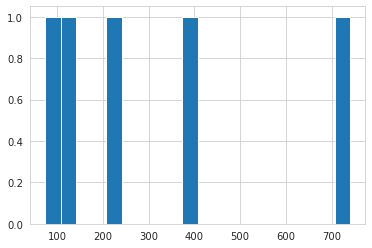

In [ ]:
collated_patch_gdf.im_id.value_counts().hist(bins=20)

Remove empty geometries that for some reason exist.

In [ ]:
collated_patch_gdf.dropna(subset=['geometry'], inplace=True)

Fix polygons so that they are not MultiPolygons and do not contain any holes.

In [ ]:
collated_patch_gdf['geometry'] = collated_patch_gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                        else Polygon(row.geometry.exterior), axis=1)

Get some information, assume that GSD is 0.04m. In reality, it's between 0.039 and 0.043.

In [ ]:
collated_patch_gdf['area'] = collated_patch_gdf.geometry.area

In [ ]:
collated_patch_gdf['pixel_area'] = collated_patch_gdf.area / 0.04**2

In [ ]:
collated_patch_gdf['scaled_pixel_area'] = collated_patch_gdf.pixel_area * (800/550)**2

In [ ]:
collated_patch_gdf['bbox_area'] = collated_patch_gdf.apply(lambda row: box(*row.geometry.bounds).area, axis=1)

In [ ]:
collated_patch_gdf['bbox_x_px'] = collated_patch_gdf.apply(lambda row: (row.geometry.bounds[2] - row.geometry.bounds[0]) / 0.04, axis=1)
collated_patch_gdf['bbox_y_px'] = collated_patch_gdf.apply(lambda row: (row.geometry.bounds[3] - row.geometry.bounds[1]) / 0.04, axis=1)

In [ ]:
collated_patch_gdf['scaled_bbox_x_px'] = collated_patch_gdf.bbox_x_px * 800/512
collated_patch_gdf['scaled_bbox_y_px'] = collated_patch_gdf.bbox_y_px * 800/512

In [ ]:
collated_patch_gdf['bbox_pixel_area'] = collated_patch_gdf.bbox_area / 0.04**2
collated_patch_gdf['scaled_bbox_pixel_area'] = collated_patch_gdf.bbox_pixel_area * (800/512)**2

In [ ]:
collated_patch_gdf = collated_patch_gdf[collated_patch_gdf.bbox_pixel_area > 16]

In [ ]:
def aspect_ratio(row):
    if row.bbox_x_px > row.bbox_y_px:
        return row.bbox_x_px / row.bbox_y_px
    else:
        return - (row.bbox_y_px) / (row.bbox_x_px)

In [ ]:
collated_patch_gdf['bbox_aspect_ratio'] = collated_patch_gdf.apply(lambda row: aspect_ratio(row), axis=1)#
#collated_patch_gdf['bbox_aspect_ratio'] = collated_patch_gdf.bbox_x_px / collated_patch_gdf.bbox_y_px

In [ ]:
collated_patch_gdf['coco_scale'] = collated_patch_gdf.apply(lambda row: 'small' if row.pixel_area < 32**2 
                                          else ('large' if row.pixel_area > 96**2 else 'medium'), axis=1)

In [ ]:
collated_patch_gdf['scaled_coco_scale'] = collated_patch_gdf.apply(lambda row: 'small' if row.scaled_pixel_area < 32**2 
                                          else ('large' if row.scaled_pixel_area > 96**2 else 'medium'), axis=1)

COCO scales are divided by pixel area. `small` is less than $32^2$ pixels, `large` is more than $96^2$ pixels and `medium` is between them.

In [ ]:
pd.crosstab(collated_patch_gdf.layer, collated_patch_gdf.coco_scale, margins=True)

coco_scale,large,medium,small,All
layer,,,,
groundwood,0,21,1206,1227
uprightwood,1,171,124,296
All,1,192,1330,1523


In [ ]:
pd.crosstab(collated_patch_gdf.layer, collated_patch_gdf.scaled_coco_scale, margins=True)

scaled_coco_scale,large,medium,small,All
layer,,,,
groundwood,0,184,1043,1227
uprightwood,11,233,52,296
All,11,417,1095,1523


As seen here, almost all of the annotated groundwood are considered `small`, while annotated uprightwood are mostly `medium`.

Area of different deadwood types, in m²

In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
layer,,,,
groundwood,0.012730,3.901515,0.468166,0.361062
uprightwood,0.026108,16.657880,2.468973,1.976078
All,0.012730,16.657880,0.857029,0.425417


Approximate area in pixels, average resolution around 0.04m so each pixel is 0.0016m²

In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,pixel_area,pixel_area,pixel_area,pixel_area
layer,,,,
groundwood,7.956467,2438.447020,292.603822,225.663876
uprightwood,16.317220,10411.174942,1543.108240,1235.048620
All,7.956467,10411.174942,535.643420,265.885788


<AxesSubplot:>

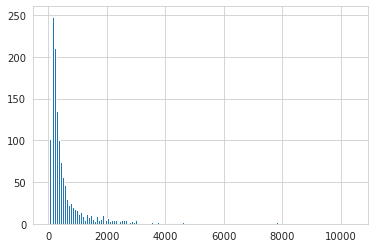

In [ ]:
collated_patch_gdf.pixel_area.hist(bins='auto')

In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='scaled_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,scaled_pixel_area,scaled_pixel_area,scaled_pixel_area,scaled_pixel_area
layer,,,,
groundwood,16.833516,5159.028406,619.062632,477.437621
uprightwood,34.522383,22026.948638,3264.757928,2612.995427
All,16.833516,22026.948638,1133.262112,562.535220


Area of bounding boxes, in pixels.

In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area
layer,,,,
groundwood,17.885119,42183.304194,1828.712016,841.980456
uprightwood,25.239518,18456.192210,2537.021757,1940.936607
All,17.885119,42183.304194,1966.374316,983.906582


In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='scaled_bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,scaled_bbox_pixel_area,scaled_bbox_pixel_area,scaled_bbox_pixel_area,scaled_bbox_pixel_area
layer,,,,
groundwood,43.664840,102986.582504,4464.628945,2055.616348
uprightwood,61.619918,45059.063013,6193.900775,4738.614763
All,43.664840,102986.582504,4800.718546,2402.115679


Aspect (width / height) ratios of bounding boxes. For reference, default ratios for Mask R-CNN are 0.5, 1, 2 so region proporsals are in 1:2, 1:1 or 2:1 ratio. Here aspect ratios for boxes with height > width are presented as negative.

In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='bbox_aspect_ratio', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio
layer,,,,
groundwood,-19.702153,18.428442,0.082510,1.019489
uprightwood,-6.985640,58.271792,0.143725,1.002915
All,-19.702153,58.271792,0.094407,1.008850


<AxesSubplot:>

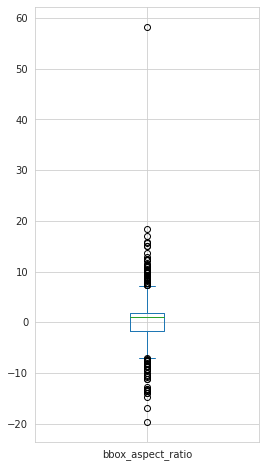

In [ ]:
collated_patch_gdf.plot(kind='box', y='bbox_aspect_ratio', grid=True, figsize=(4,8))

<AxesSubplot:title={'center':'Distribution of bounding box aspect ratios'}, ylabel='Frequency'>

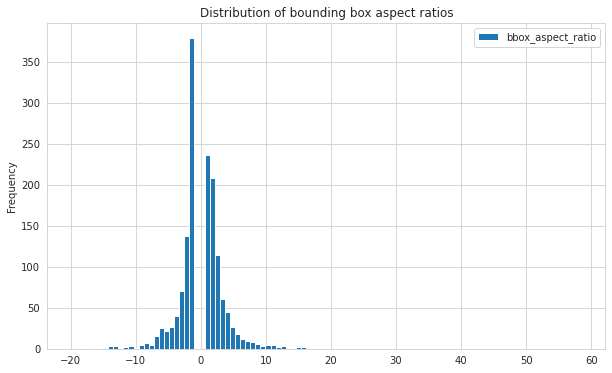

In [ ]:
collated_patch_gdf.plot(kind='hist', y='bbox_aspect_ratio', bins=100, grid=True, 
               title='Distribution of bounding box aspect ratios',
               figsize=(10,6))

As expected, groundwood has weird aspect ratios.

Widths of bounding boxes, in pixels. Default anchor sizes for Mask R-CNN are 32, 64, 128, 256 and 512 pixels, but for images with minimum width of 800px and maximum width of 1333px. Our images are between 510-580 pixels so those bounding boxes are upsampled accordingly.

In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='bbox_x_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_x_px,bbox_x_px,bbox_x_px,bbox_x_px
layer,,,,
groundwood,1.436056,317.064430,37.047597,29.124692
uprightwood,2.843247,194.248669,54.773046,50.385454
All,1.436056,317.064430,38.812191,31.226285


In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='scaled_bbox_x_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,scaled_bbox_x_px,scaled_bbox_x_px,scaled_bbox_x_px,scaled_bbox_x_px
layer,,,,
groundwood,2.243838,495.413173,57.886870,45.507330
uprightwood,4.442574,303.513545,85.582885,78.727272
All,2.243838,495.413173,60.644049,48.791070


Heights of bounding boxes, in pixels.

In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='bbox_y_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_y_px,bbox_y_px,bbox_y_px,bbox_y_px
layer,,,,
groundwood,2.138157,257.619522,38.723550,31.328844
uprightwood,1.875819,178.739983,54.621764,52.330156
All,1.875819,257.619522,40.306240,33.601973


In [ ]:
pd.pivot_table(collated_patch_gdf, index='layer', values='scaled_bbox_y_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,scaled_bbox_y_px,scaled_bbox_y_px,scaled_bbox_y_px,scaled_bbox_y_px
layer,,,,
groundwood,3.340871,402.530503,60.505547,48.951318
uprightwood,2.930967,279.281223,85.346506,81.765869
All,2.930967,402.530503,62.978501,52.503082


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

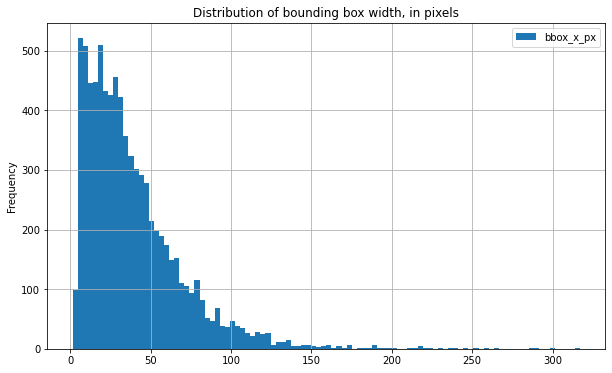

In [ ]:
collated_patch_gdf.plot(kind='hist', y='bbox_x_px', bins=100, grid=True, 
               title='Distribution of bounding box width, in pixels',
               figsize=(10,6))

<AxesSubplot:title={'center':'Distribution of bounding box height, in pixels'}, ylabel='Frequency'>

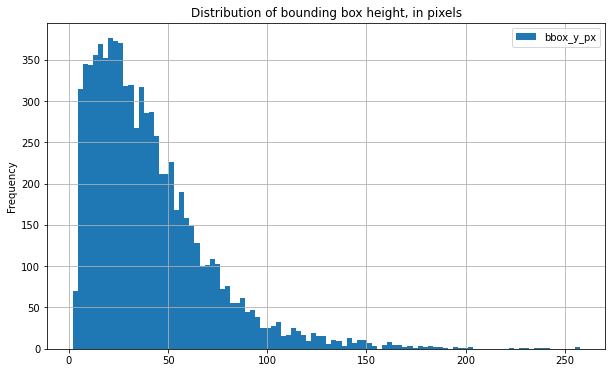

In [ ]:
collated_patch_gdf.plot(kind='hist', y='bbox_y_px', bins=100, grid=True, 
               title='Distribution of bounding box height, in pixels',
               figsize=(10,6))

In [ ]:
collated_patch_gdf['length'] = collated_patch_gdf.apply(lambda row: get_len(row.geometry), axis=1)

<AxesSubplot:title={'center':'Distribution of groundwood length in meters'}, ylabel='Frequency'>

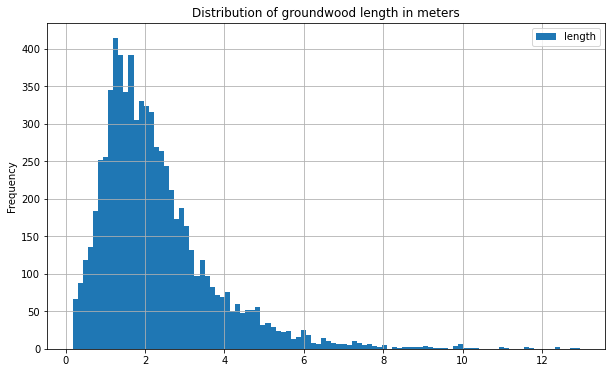

In [ ]:
collated_patch_gdf[collated_patch_gdf.layer=='groundwood'].plot(kind='hist', y='length', bins=100, grid=True, 
                                              title='Distribution of groundwood length in meters',
                                              figsize=(10,6))


<AxesSubplot:title={'center':'Distribution of uprightwood maximum canopy diameter, in meters'}, ylabel='Frequency'>

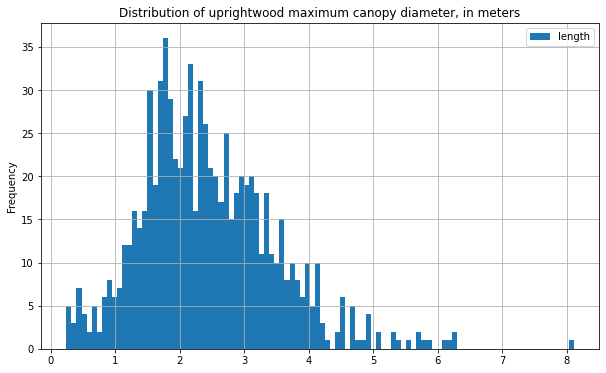

In [ ]:
collated_patch_gdf[collated_patch_gdf.layer=='uprightwood'].plot(kind='hist', y='length', bins=100, grid=True, 
                                               title='Distribution of uprightwood maximum canopy diameter, in meters',
                                               figsize=(10,6))